In [ ]:
#default_exp augmentations

# augmentations

>Implmentation heavily inspired by Ignacio Oguiza - oguiza@gmail.com

In [ ]:
#export
import random
from functools import partial
from scipy.interpolate import CubicSpline
from torchtools.data import *

In [ ]:
#export
import numpy as np
import torch

from fastai2.torch_basics import *
from fastai2.data.all import *

from torchtools.data import *

There are 3 types of noise adding augmentations that can be applied to timeseries data
- scaling: the same noise is a applied to each data point, e.g., each data point is multiplied by a scaling factor f
- jittering: the noise is different for each datapoint, e.g., pick a random scaling factor f_i for each of the data points
- warping: warping is similar to jittering, but the noise is picked from a smooth random curve

These augmentations can be applied to both the y-axis, i.e., the values of the data points, and the x-axis, i.e., the time values of the data points. In case of adding noise to the x-axis of the timeseries data, we usually need to interpolate the corresponding y-value using some kind of piecewise interpolation approach, e.g. CubicSplines

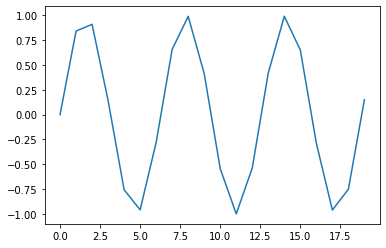

In [ ]:
## set up some sample data
sample_sin = torch.tensor(np.sin(np.arange(20)))[None,:] #one channel
plt.plot(sample_sin[0]);

t = torch.randn((4,20))
ts_tensor = TSTensor(t)

#### Helper Function

In [ ]:
def _get_sin(dims=(1,20)): return torch.tensor([np.sin(x) for x in np.arange(dims[1])]).unsqueeze(0)
def _get_log(dims=(1,20)): return torch.tensor([np.log(x+1) for x in np.arange(dims[1])]).unsqueeze(0)

Cubic Splines are used for smooth, piecewise interpolation of a sequence of datapoints
- piecewise cubic polynomials
- twice continuously differentiable, i.e. smooth

We use cubic splines both to create random curves for sampling noise for warping and interpolating data points in the case of x-axis noise.

In the example below, we add some noise to our sample data and interpolate the data points with a cubic spline. Since we now have a continuous interpolation of the original data, we can add noise to the x-axis, the interval [0:19] and use the corresponding interpolation values.

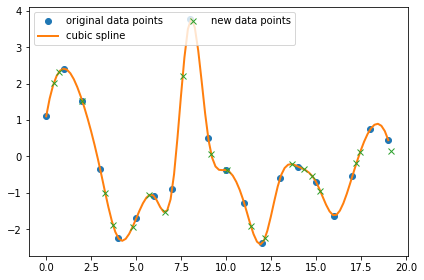

In [ ]:
#hide
rand_noise = torch.randn(sample_sin.shape)
sample_sin = sample_sin+rand_noise
plt.plot(sample_sin[0], 'o', linewidth=1, label='original data points');
cspline = CubicSpline(np.arange(20), sample_sin[0])
plt.plot(np.linspace(0,19, num=100), cspline(np.linspace(0,19, num=100)), linewidth=2, label='cubic spline');
xs_noise = np.arange(20)+np.random.normal(0,0.4, size=20)
plt.plot(xs_noise, cspline(xs_noise), 'x', label='new data points')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show();

In [ ]:
#exports
#oguiza implementation, only used for _magwarp
# def random_curve_generator(ts, magnitude=.1, order=4, noise=None):
#     '''
#     sample points from a gaussian with mean 1 and create a smooth cubic "random curve" from these points
#     '''
#     seq_len = ts.shape[-1]
#     x = np.linspace(-seq_len, 2 * seq_len - 1, 3 * (order - 1) + 1, dtype=int)
#     x2 = np.random.normal(loc=1.0, scale=magnitude, size=len(x))
#     f = CubicSpline(x, x2, axis=-1)
#     return f(np.arange(seq_len))

In [ ]:
#exports

def _create_random_curve(n_channels, seq_len, magnitude, order):
    '''
    create a random curve for each channel in the interval[0, seq_len-1] on order random points
    '''
    x = np.linspace(0, seq_len-1, order)
    y = np.random.normal(loc=1.0, scale=magnitude, size=(n_channels, len(x)))
    f = CubicSpline(x, y, axis=-1)
    return f

def noise_from_random_curve(dim, magnitude=.1, order=4):
    '''
    sample points from a gaussian with mean 1 and create a smooth cubic "random curve" from these points
    ts, needs to be 2D
    order: number of sample to create the random curve from
    '''
    n_channels, seq_len = dim
    f = _create_random_curve(n_channels, seq_len, magnitude, order)
    return torch.tensor(f(np.arange(seq_len)))

def noise_from_normal(dim, magnitude=.1):
    '''
    sample random noise from a gaussian with mean=1.0 and std=magnitude
    '''
    n_channels, seq_len = dim
    return torch.tensor(np.random.normal(loc=1.0, scale=magnitude, size=(n_channels, seq_len)))

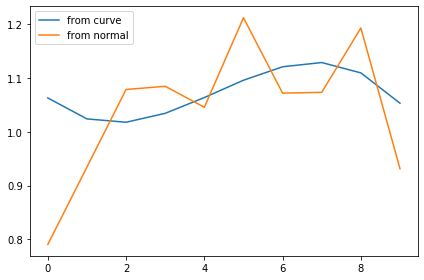

In [ ]:
t = (1,10)
plt.plot(noise_from_random_curve(t).T, label='from curve')
plt.plot(noise_from_normal(t).T, label='from normal')
plt.legend()
plt.tight_layout();

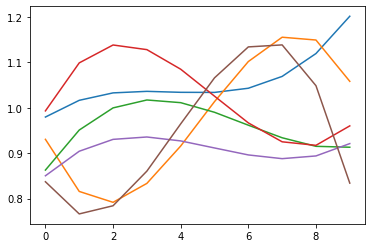

In [ ]:
plt.plot(noise_from_random_curve((6,10)).T);

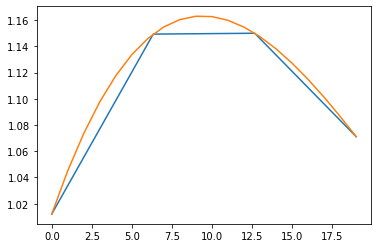

In [ ]:
samples = np.random.normal(loc=1.0, scale=0.1, size=4)
plt.plot(np.linspace(0,19,4), samples);
rcurve = CubicSpline(np.linspace(0,19,4), samples)
# plt.plot(np.linspace(0,19,100), rcurve(samples));

plt.plot(rcurve(np.arange(20)));

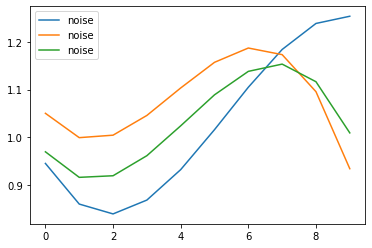

In [ ]:
#multiple channels
plt.plot(noise_from_random_curve((3,10)).T, label='noise')
plt.legend();

In [ ]:
n_channels = 3; seq_len=20; magnitude=0.2
noise = torch.normal(0, magnitude, (n_channels, seq_len))
noise.shape, noise_from_normal((n_channels, seq_len)).shape

(torch.Size([3, 20]), torch.Size([3, 20]))

#### Y Noise

In [ ]:
#export
def _ynoise(x, magnitude=.1, add=True, smooth=True, **kwargs):
    '''
    add random noise to timeseries values
    '''
#     assert isinstance(x, Tensor)
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    if magnitude <= 0: return x
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    noise_fn = noise_from_random_curve if smooth else noise_from_normal
    
    noise = noise_fn((n_channels, seq_len), magnitude=magnitude, **kwargs).to(x.device)
    if add:
        output = x + (noise-1)
        return output.to(x.device, x.dtype)
    else:
        output = x * (noise)
        return output.to(x.device, x.dtype) 

In [ ]:
#export
_ynoise_warp = partial(_ynoise, smooth=True)
_ynoise_normal = partial(_ynoise, smooth=False)

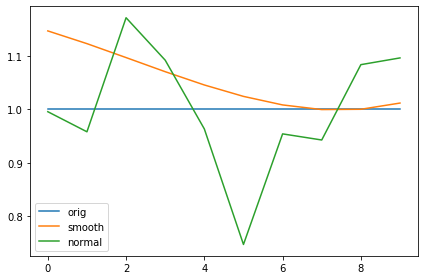

In [ ]:
t = torch.ones(1,10)
plt.plot(t.T, label='orig')
plt.plot(_ynoise_warp(t).T, label='smooth')
plt.plot(_ynoise_normal(t).T, label='normal')
plt.legend()
plt.tight_layout();

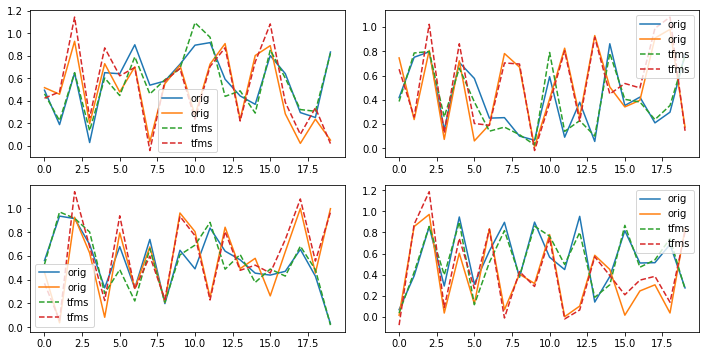

In [ ]:
## batch transform
t = torch.rand(4,2,20)
t_tfmd = _ynoise_normal(t)
_, axes = plt.subplots(2,2, figsize=(10,5))
for i,ax in enumerate(axes.flatten()):
    ax.plot(t[i].T, label='orig')
    ax.plot(t_tfmd[i].T, linestyle='dashed', label = 'tfms')
    ax.legend()
plt.tight_layout()

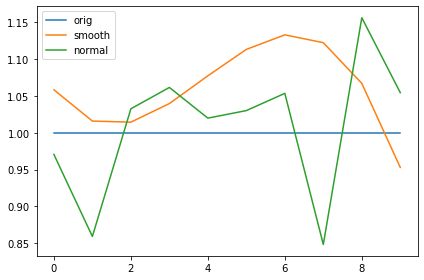

In [ ]:
t = torch.ones(1,10)
plt.plot(t.T, label='orig')
plt.plot(_ynoise_warp(t, add=False).T, label='smooth')
plt.plot(_ynoise_normal(t, add=False).T, label='normal')
plt.legend()
plt.tight_layout();

In [ ]:
#export
def _yscale(x, magnitude=.1, normal=False):
    if magnitude <= 0: return x
    if normal: 
        scale = 1.+(torch.randn(1))*magnitude
    else:
        scale = 1 + torch.rand(1) * magnitude  # uniform [0:1], normal possible
        if np.random.rand() < .5: scale = 1 / scale # scale down
    output = x * scale.to(x.device)
    return output

In [ ]:
t = torch.arange(5)
t,_yscale(t), _yscale(t, normal=True)

(tensor([0, 1, 2, 3, 4]),
 tensor([0.0000, 1.0891, 2.1782, 3.2674, 4.3565]),
 tensor([0.0000, 1.0020, 2.0041, 3.0061, 4.0081]))

### Distorting the X-axis (Time)

#### Time Warping

In [ ]:
#x-axis noise, cumulative, oguiza
# def random_intervals_from_curve(ts, magnitude=.1, order=4, noise=None):
#     '''noise to `[0,..., seq_len]` by sampling deltas from a random curve'''
#     noise_cum = noise_from_random_curve(ts, magnitude=magnitude, order=order).cumsum(1)
#     noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
#     noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
# #     x /= x[-1]
# #     x = np.clip(x, 0, 1)
# #     print(x)
# #     return x * (ts.shape[-1] - 1)
#     return noise_cum

In [ ]:
#x-axis noise, cumulative, oguiza
# def random_intervals_from_normal(ts, magnitude=.1, order=4, noise=None):
#     '''noise to `[0,..., seq_len]` by sampling deltas from a random curve'''
#     noise_cum = noise_from_normal(ts, magnitude=magnitude).cumsum(1)
#     noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
#     noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
# #     x /= x[-1]
# #     x = np.clip(x, 0, 1)
# #     print(x)
# #     return x * (ts.shape[-1] - 1)
#     return noise_cum

In [ ]:
#export
def _normalize_timesteps(timesteps):
    '''
    distorted timesteps in [0,..,seq_len]
    '''
#     timesteps = timesteps - np.expand_dims(timesteps[:,0], -1)
#     timesteps = timesteps.clone()
    timesteps = timesteps.sub(timesteps[:,0].unsqueeze(-1))

#     timesteps = timesteps/np.expand_dims(timesteps[:,-1], -1) * (timesteps.shape[1]-1)
    timesteps=timesteps.div(timesteps[:,-1].unsqueeze(-1)) * (timesteps.shape[1]-1)
    
    return timesteps
    

def distort_time(dim, magnitude=.1, smooth=False, **kwargs):
    '''
    distort the time steps (x-axis) of timeseries
    '''
    n_channels, seq_len = dim
    noise_fn = noise_from_random_curve if smooth else noise_from_normal
    noise = noise_fn((n_channels, seq_len), magnitude=magnitude, **kwargs)
    time_new = _normalize_timesteps(noise.cumsum(1))
#     noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
#     noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
#     x /= x[-1]
#     x = np.clip(x, 0, 1)
#     print(x)
#     return x * (ts.shape[-1] - 1)
    return time_new

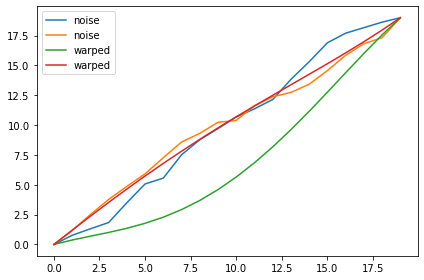

In [ ]:
t=(2,20)
plt.plot(distort_time(t, 0.5).T, label='noise')
plt.plot(distort_time(t, 0.5, smooth=True).T, label='warped')
plt.legend()
plt.tight_layout();


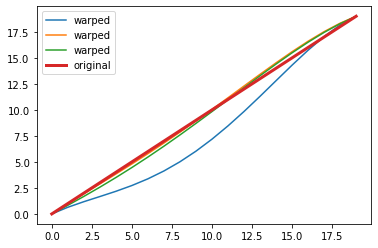

In [ ]:
plt.plot(distort_time((3,20), magnitude=0.3, smooth=True).T, label='warped')
plt.plot(np.arange(20), label='original', linewidth=3)
plt.legend();

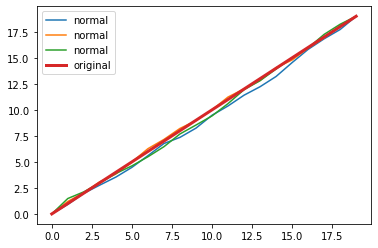

In [ ]:
plt.plot(distort_time((3,20), magnitude=0.3).T, label='normal')
plt.plot(np.arange(20), label='original', linewidth=3)
plt.legend();

In [ ]:
#export
def _timenoise(x, magnitude=.1, smooth=False, **kwargs):
    '''This is a slow batch tfm on cpu'''
    if magnitude <= 0: return x
#     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only works on cpu
    
#    return f
#     plt.plot(x.T)
#     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
    new_x = distort_time((n_channels,seq_len), magnitude=magnitude, smooth=True, **kwargs).to(x.device)
    fs = [CubicSpline(np.arange(seq_len), x[...,i,:], axis=-1) for i in range(n_channels)]
#     new_y = f(new_x, )
#     print(fs(new_x).shape)
#     return new_x
    new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)])
    if len(x.shape)==3: new_y = new_y.permute(1,0,2)
    
    return new_y.to(x_device, x.dtype)

In [ ]:
def _zoomin(x, magnitude=.2):
    '''This is a slow batch tfm'''
    if magnitude == 0: return x

    n_channels, seq_len = x.shape[-1], x.shape[-1]
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    lambd = np.random.beta(magnitude, magnitude)
    lambd = max(lambd, 1 - lambd)
    win_len = int(seq_len * lambd)
    if win_len == seq_len: start = 0
    else: start = np.random.randint(0, seq_len - win_len)
    print(start, win_len)
    x2 = x[..., start : start + win_len]
    f = CubicSpline(np.arange(x2.shape[-1]), x2, axis=-1)
    output = x.new(f(np.linspace(0, win_len - 1, num=seq_len)))
    return output


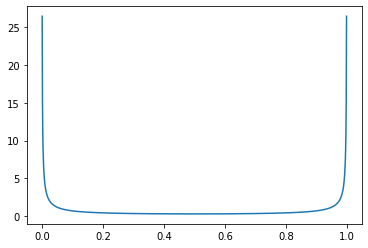

In [ ]:
import scipy.stats as ss

for mag in np.linspace(0.2, 0.9, 1):
    x = np.linspace(0,1,1000)
    y = ss.beta.pdf(x, mag, mag)
    plt.plot(x,y);

2 6


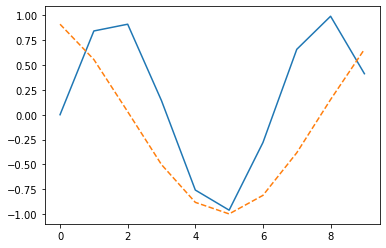

In [ ]:
t = _get_log((2,10))
t = _get_sin((2,10))

# t,_zoomin(t)
plt.plot(t.T)
plt.plot(_zoomin(t, 0.3).T, linestyle='dashed');

In [ ]:
#export
def _timewarp(x, magnitude=.1, order=4):
    return _timenoise(x, magnitude, smooth=True, order=order)
def _timenormal(x, magnitude=.1):
    return _timenoise(x, magnitude, smooth=False)

In [ ]:
# #export
# def _timewarp(x, magnitude=.1, order=4):
#     '''This is a slow batch tfm on cpu'''
#     if magnitude <= 0: return x
# #     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
#     assert len(x.shape)==2, 'only 2D tensors supported'
#     n_channels, seq_len = x.shape
#     x_device = x.device ## make sure to put outpout on right device
#     x=x.cpu() ## only works on cpu
    
# #    return f
# #     plt.plot(x.T)
# #     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
#     new_x = distort_time(x, magnitude=magnitude, smooth=True, order=order)
#     fs = [CubicSpline(np.arange(seq_len), xi, axis=-1) for xi in x]
# #     new_y = f(new_x, )
#     new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)] )
#     return new_y.to(x_device)


In [ ]:
# #export
# def _timenoise(x, magnitude=.1, order=4):
#     '''This is a slow batch tfm on cpu'''
#     if magnitude <= 0: return x
# #     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
#     assert len(x.shape)==2, 'only 2D tensors supported'
#     n_channels, seq_len = x.shape
#     x_device = x.device ## make sure to put outpout on right device
#     x=x.cpu() ## only works on cpu
    
# #    return f
# #     plt.plot(x.T)
# #     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
#     new_x = distort_time(x, magnitude=magnitude)
#     fs = [CubicSpline(np.arange(seq_len), xi, axis=-1) for xi in x]
# #     new_y = f(new_x, )
#     new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)] )
#     return new_y.to(x_device)


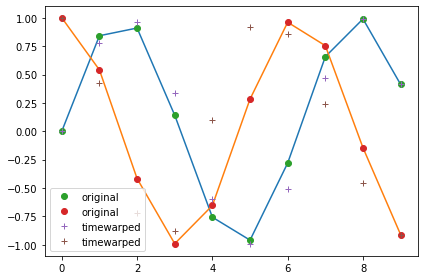

In [ ]:
t1 = torch.tensor([np.sin(x) for x in range(10)])
t2 = torch.tensor([np.cos(x) for x in range(10)])
t3 = torch.stack((t1,t2))
t4 = torch.rand(5,20)

# _timewarp(t1)
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timewarp(t).shape == t.shape
plt.plot(t3.T);    
plt.plot(t3.T, 'o', label='original')
plt.plot(_timewarp(t3, 0.2).T, '+', label='timewarped')
plt.tight_layout()
plt.legend();

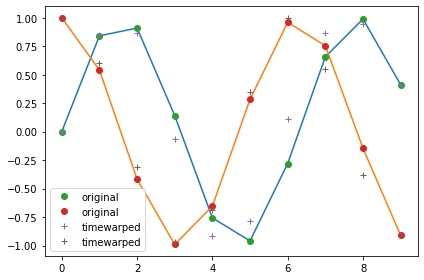

In [ ]:
#cuda
t1 = torch.tensor([np.sin(x) for x in range(10)]).cuda()
t2 = torch.tensor([np.cos(x) for x in range(10)]).cuda()
t3 = torch.stack((t1,t2))
t4 = torch.rand(5,20)

# _timewarp(t1)
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timewarp(t).shape == t.shape
plt.plot(t3.cpu().T);    
plt.plot(t3.cpu().T, 'o', label='original')
plt.plot(_timewarp(t3, 0.2).cpu().T, '+', label='timewarped')
plt.tight_layout()
plt.legend();

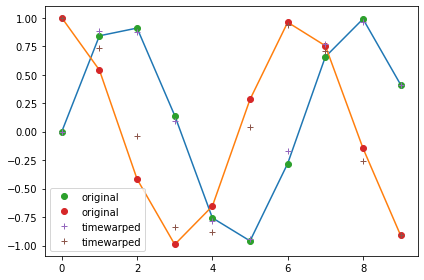

In [ ]:
t1 = torch.tensor([np.sin(x) for x in range(10)])
t2 = torch.tensor([np.cos(x) for x in range(10)])
t3 = torch.stack((t1,t2))
t4 = torch.rand(5,20)

# _timewarp(t1)
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timewarp(t).shape == t.shape
plt.plot(t3.T);    
plt.plot(t3.T, 'o', label='original')
plt.plot(_timewarp(t3, 0.2).T, '+', label='timewarped')
plt.tight_layout()
plt.legend();

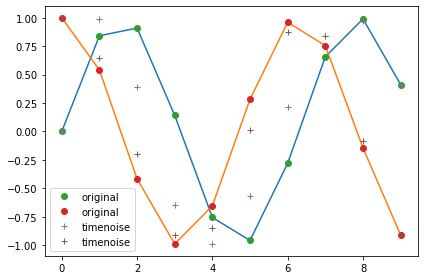

In [ ]:
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timenormal(t).shape == t.shape
plt.plot(t3.T);    
plt.plot(t3.T, 'o', label='original')
plt.plot(_timenormal(t3, 0.2).T, '+', label='timenoise')
plt.tight_layout()
plt.legend();

In [ ]:
_timewarp(t)

tensor([[0.7163, 0.5094, 0.0531, 0.8017, 0.5232, 0.7018, 0.1517, 0.6626, 0.8365,
         0.8540, 0.5858, 0.9151, 0.6327, 0.4031, 0.8573, 0.9456, 0.7179, 0.6514,
         0.8875, 0.4119],
        [0.2451, 0.5405, 0.9046, 0.0953, 0.3983, 0.6323, 0.5726, 0.8271, 0.8329,
         0.7077, 0.6808, 0.6089, 0.3332, 0.0328, 0.8886, 0.4903, 0.8467, 0.3238,
         0.5120, 0.0781],
        [0.0901, 0.3491, 0.2335, 0.5183, 0.5016, 0.3195, 0.6278, 0.3361, 0.8034,
         0.7285, 0.8413, 0.5621, 0.0883, 0.4853, 0.8197, 0.8244, 0.5141, 0.2329,
         0.3473, 0.1219],
        [0.3516, 0.1816, 0.4267, 0.1017, 0.5959, 0.7343, 0.7220, 0.7355, 0.5406,
         0.8417, 0.7898, 0.2133, 0.8461, 0.3718, 0.7150, 0.8070, 0.9508, 0.7596,
         0.0956, 0.9082],
        [0.2363, 0.6231, 0.7773, 0.1539, 0.4829, 0.2990, 0.8732, 0.4789, 0.7670,
         0.4180, 0.1857, 0.9617, 0.4881, 0.7334, 0.5280, 0.4578, 0.2299, 0.8583,
         0.0198, 0.3456]])

### Zoom

In [ ]:
def _zoomin(x, magnitude=.2):
    '''This is a slow batch tfm'''
    if magnitude == 0: return x

    seq_len = x.shape[-1]
    lambd = np.random.beta(magnitude, magnitude)
    lambd = max(lambd, 1 - lambd)
    win_len = int(seq_len * lambd)
    if win_len == seq_len: start = 0
    else: start = np.random.randint(0, seq_len - win_len)
    x2 = x[..., start : start + win_len]
    f = CubicSpline(np.arange(x2.shape[-1]), x2, axis=-1)
    output = x.new(f(np.linspace(0, win_len - 1, num=seq_len)))
    return output if y is None else [output, y]


### Transforms

In [ ]:
# class TimeWarp(Transform):
#     order=200
#     def encodes(self, x:TSTensor):
#         print('timewarp')
#         return _timewarp(x)

In [ ]:
#export
@delegates(Transform.__init__)
class AugTransform(Transform):
    split_idx=0
    def __init__(self, magnitude=0.1, **kwargs):
        super().__init__(**kwargs)
        self.magnitude=magnitude
        
    def __call__(self, x, split_idx=split_idx):
        return super().__call__(x, split_idx=split_idx)

In [ ]:
#export
@delegates()
class YWarp(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        print('ywarp')
        return _ynoise_warp(x, magnitude=self.magnitude)

In [ ]:
yw=YWarp(magnitude=0.5, order=5)

In [ ]:
yw.magnitude

0.5

In [ ]:
x = TSTensor(torch.ones(2,1,10))

In [ ]:
x

TSTensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

In [ ]:
yw(TSTensor(torch.ones(2,1,5)), split_idx=0)

ywarp


TSTensor([[[1.3346, 1.5957, 1.4636, 1.0681, 0.5386]],

        [[1.3346, 1.5957, 1.4636, 1.0681, 0.5386]]])

In [ ]:
#export
class YNormal(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        print('ynormal')
        return _ynoise_normal(x)

In [ ]:
#export
class YScale(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        print('yscale')
        return _yscale(x)

In [ ]:
#export
class TimeWarp(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        print('timewarp')
        return _timewarp(x)

In [ ]:
#export
class TimeNormal(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        print('timenormal')
        return _timenormal(x, magnitude=self.magnitude)

In [ ]:
#export
def _all_noise_augs(magnitude=0.1):
    return [YWarp(magnitude=magnitude), YNormal(magnitude=magnitude), YScale(magnitude=magnitude),
           TimeWarp(magnitude=magnitude), TimeNormal(magnitude=magnitude)]

In [ ]:
class A:
    def __init__(self, a):
        self.a=a
class B(A):
    def __init__(self, a,b):
        super().__init__(b)
        self.b=a

In [ ]:
augs = _all_noise_augs()

In [ ]:
augs

[YWarp: False (TSTensor,object) -> encodes ,
 YNormal: False (TSTensor,object) -> encodes ,
 YScale: False (TSTensor,object) -> encodes ,
 TimeWarp: False (TSTensor,object) -> encodes ,
 TimeNormal: False (TSTensor,object) -> encodes ]

In [ ]:
augs[0](TSTensor(torch.ones(2,3,10)), split_idx=None).shape

torch.Size([2, 3, 10])

In [ ]:
ts_ones = TSTensor(torch.ones(1,10))
compose_tfms(ts_ones, [TimeWarp(), YScale()])
compose_tfms(ts_ones, augs)


timewarp
yscale
ywarp
ynormal
yscale
timewarp
timenormal


TSTensor([[1.1490, 1.0421, 1.0930, 1.0576, 1.1069, 0.9560, 0.8464, 1.0212, 1.1008,
         1.0395]])

In [ ]:
#export
class RandAugment(AugTransform):
    def __init__(self, N=2, magnitude=0.2, tfms=None, **kwargs):
        super().__init__(**kwargs)
        self.N = N
        if tfms is None: self.tfms = _all_noise_augs(magnitude)
            
    def encodes(self, x:TSTensor):
        fs = np.random.choice(self.tfms, 2, replace=False)
        return compose_tfms(x, fs)
    

yscale
timewarp
timenormal
ynormal
ywarp
timenormal
yscale
timenormal
ywarp
yscale


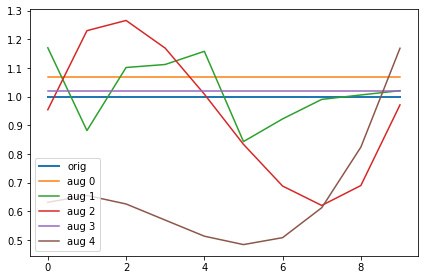

In [ ]:
ts_ones = TSTensor(torch.ones(1,10))
plt.plot(ts_ones.T, linewidth=2, label='orig')
rand_aug = RandAugment(N=2, magnitude=0.2)
for i in range(5):
    plt.plot(rand_aug(ts_ones).T, label=f'aug {i}')
plt.legend()
plt.tight_layout()

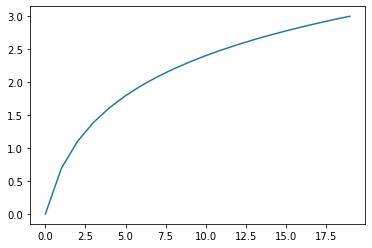

In [ ]:
plt.plot([np.log(x+1) for x in range(20)])

In [ ]:
def _get_sin(dims=(1,20)): return torch.tensor([np.sin(x) for x in np.arange(dims[1])]).unsqueeze(0)
def _get_log(dims=(1,20)): return torch.tensor([np.log(x+1) for x in np.arange(dims[1])]).unsqueeze(0)


yscale
timenormal
timenormal
yscale
timenormal
ywarp


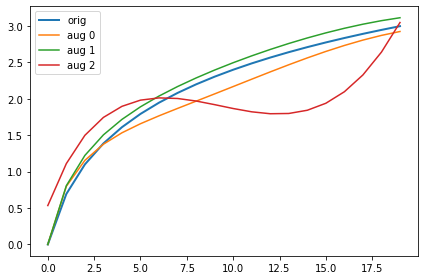

In [ ]:
ts = TSTensor(_get_log())
plt.plot(ts.T, linewidth=2, label='orig')
rand_aug = RandAugment(N=2, magnitude=0.5)
for i in range(3):
    plt.plot(rand_aug(ts).T, label=f'aug {i}')
plt.legend()
plt.tight_layout()

In [ ]:
ts_ones = TSTensor(torch.ones(1,50))
tn = TimeNormal(0.4)
print(tn.magnitude)
(TSTensor(torch.ones(1,5)))

0.4


TSTensor([[1., 1., 1., 1., 1.]])

In [ ]:
ts_ones = TSTensor(torch.ones(1,10))
compose_tfms(ts_ones, [TimeWarp(), YScale()])

timewarp
yscale


TSTensor([[0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847,
         0.9847]])

In [ ]:
class YWarp(Transform): pass
@YWarp
def encodes(self, x:TSTensor): return _ynoise_warp(x)
@YWarp
def encodes(self, x:np.ndarray): ##just for testing
#     print(type(x))
    return _ynoise_warp(TSTensor(torch.tensor(x)))

In [ ]:
_ynoise_warp(TSTensor(torch.ones(1,5)))

TSTensor([[1.1136, 1.2200, 1.0120, 0.8491, 1.0911]])

In [ ]:
print(YWarp()(np.ones(shape=(1,5))))
print(YWarp()(TSTensor(torch.ones(1,5))))

TSTensor([[1.0821, 1.1525, 1.2013, 1.1655, 0.9820]])
TSTensor([[0.9880, 0.9171, 1.0345, 1.1728, 1.1650]])


In [ ]:
YWarp()

YWarp: False (ndarray,object) -> encodes
(TSTensor,object) -> encodes 

In [ ]:
isinstance(np.ones((1,5)), np.ndarray)

True

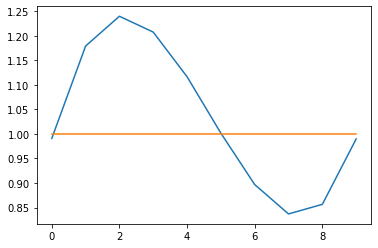

In [ ]:
ts_tensor = TSTensor(torch.ones(1,10))
plt.plot(YWarp()(ts_tensor).T)
plt.plot(YNormal()(ts_tensor).T);

In [ ]:
RandAugment(N=2, magnitude=0.2)


TypeError: __init__() got an unexpected keyword argument 'magnitude'

#### Test NB

In [ ]:
from nbdev.cli import test_nb

In [ ]:
# test_nb('./_20_augmentations.ipynb')